In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, lax, vmap, jacobian
import jax.scipy.linalg as jsl

import jax

import numpy as np
from read_traj_v2 import *

import scipy.optimize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
mol = 'heh+'
basis = 'sto-3g'
init = 'hf'
td = 'rt-tdexx'

dt = 0.08268/10

inpath = './correctdata'
inpath2 = './mydata/'
outpath = './'
saved_model_dir = './models/'

trnfrq = jnp.array(np.load('./tdcasscf_data/tdcasscf_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcasscf_data/tdcasscf_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcasscf_data/tdcasscf_trntme_dt0.008268.npz'))

In [3]:
trnden = np.array(np.load('./tdcasscf_data/tdcasscf_dt0.0082680.npz'))
print(trnden.shape)

(301, 20000, 2, 2)


In [4]:
trntimecoeffs = np.array(np.load('./tdcasscf_data/time_coeffs_tdcasscf_dt0.008268.npz'))
print(trntimecoeffs.shape)

(300, 10000, 4)


In [5]:
S = np.array([[1.      , 0.538415],
        [0.538415, 1.      ]])

In [6]:
sys = 'heh+'
c0hf = 0.9625707
c1hf = -0.13322676E-14 
c2hf = -0.2691179
c3hf = 0.0321435

c2b1b0 = 0.1903932
c2b1b1 = 0.70710678
c2b1b2 = 0.6809922 
c2b1b3 = 0.0000088

c2a1a0 = c2b1b0
c2a1a1 = -0.70710678 
c2a1a2 = c2b1b2
c2a1a3 = c2b1b3

c22110 = -0.0309597 
c22111 = 0.57112365E-16
c22112 = 0.0086428
c22113 = 0.9994833

In [7]:
phi1 = np.array([0.000365,0.999803]).reshape((2,1))
phi2 = np.array([1.186690, -0.639239]).reshape((2,1))
chf = {0: c0hf, 1: c1hf, 2:  c2hf, 3: c3hf }
c2b1b = {0: c2b1b0, 1: c2b1b1, 2:  c2b1b2, 3:c2b1b3 }
c2a1a = {0: c2a1a0, 1: c2a1a1, 2:  c2a1a2, 3: c2a1a3}
c2211 = {0: c22110, 1: c22111, 2:  c22112, 3: c22113}

In [8]:
tens = np.zeros((4,4,2,2))
for i in range(0,4):
    for j in range(0,4):
        tens [i,j,:,:] = (chf[i]*chf[j] *(phi1 @phi1.T) + (1/2)*c2a1a[i]*c2a1a[j]*(phi1 @phi1.T + phi2 @phi2.T) 
                                           +(1/2) * c2b1b[i]*c2b1b[j]*(phi1 @phi1.T + phi2 @phi2.T) + c2211[i]*c2211[j]*(phi2 @phi2.T)
                                          +(1/2) * (chf[i]*c2a1a[j] * (phi1 @ phi2.T) + c2a1a[i]*chf[j]*(phi2 @ phi1.T))
                                          -(1/2) * (chf[i]*c2b1b[j] * (phi1 @ phi2.T) + c2b1b[i]*chf[j]*(phi2 @ phi1.T))
                                          -(1/2) * (c2a1a[i]*c2211[j] * (phi1 @ phi2.T) + c2211[i]*c2a1a[j]*(phi2 @ phi1.T))
                                          +(1/2) * (c2b1b[i]*c2211[j] * (phi1 @ phi2.T) + c2211[i]*c2b1b[j]*(phi2 @ phi1.T)))
        #print('TRACE: ',np.trace(tens [i,j,:,:]),str(i)+str(j))
    
#tens

In [9]:
rdmAO = np.einsum('ni,nj,ijab->nab',trntimecoeffs[141], np.conjugate(trntimecoeffs[141]), tens)

In [10]:
torch.set_default_dtype(torch.float64)
input_size = 16
output_size = 8
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()                    
        # layer 1
        self.fc1 = nn.Linear(input_size, 256) 
        self.batch1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.25)

        # layer 2
        self.fc2 = nn.Linear(256, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.25)

        # layer 3
        self.fc3 = nn.Linear(256, 256)
        self.batch3 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.25)

        # layer 4
        self.fc4 = nn.Linear(256, 256)
        self.batch4 = nn.BatchNorm1d(256)
        self.drop4 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(256, output_size)
        
        self.selu = nn.SELU() 
        self.sm = nn.Softmax(dim=1)
    def forward(self, x):                            

        # layer 1
        out = self.fc1(x)
        out = self.batch1(out)
        out = self.selu(out)
        #out = self.drop1(out)

        # layer 2
        out = self.fc2(out)
        out = self.batch2(out)
        out = self.selu(out)
        #out = self.drop2(out)

        # layer 3
        out = self.fc3(out)
        out = self.batch3(out)
        out = self.selu(out)
        #out = self.drop3(out)

        # layer 4
        out = self.fc4(out)
        out = self.batch4(out)
        out = self.selu(out)
        #out = self.drop4(out)

        out = self.fc5(out)
        #out = self.sm(out)
        return out


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('using gpu')

using gpu


In [12]:
#TODO split into real and imaginary parts
traj = 141
X = rdmAO.reshape((10000,4))
y = trntimecoeffs[traj]
X.shape, y.shape

((10000, 4), (10000, 4))

In [13]:
X

array([[ 0.05239776-2.69408607e-23j, -0.02787389+2.01686567e-22j,
        -0.02787389-2.15212462e-22j,  0.97761683+6.13050458e-24j],
       [ 0.05239773+1.84831573e-22j, -0.02787388+6.16386918e-22j,
        -0.02787388-6.40927611e-22j,  0.97761684-1.76088362e-23j],
       [ 0.05239767-3.98667021e-22j, -0.02787384+1.40912261e-21j,
        -0.02787384-1.09227154e-21j,  0.97761687-1.23040256e-22j],
       ...,
       [ 0.02402597+3.26954718e-19j, -0.01258339+4.13881474e-18j,
        -0.01258339-2.80410257e-18j,  0.98952333-4.82808780e-20j],
       [ 0.02377455-4.53586143e-19j, -0.01244789+2.47503027e-18j,
        -0.01244789-2.73337532e-18j,  0.98962884-3.29495816e-19j],
       [ 0.0235333 -6.26804381e-19j, -0.01231787+2.58895620e-18j,
        -0.01231787-2.61944939e-18j,  0.98973009-2.07523072e-20j]])

In [14]:
centered_X = X-np.mean(X)
sclfac = np.max(np.abs(centered_X))
print(sclfac)
X = centered_X/sclfac
#X = (X - np.min(X))/(np.max(X)-np.min(X))

0.7651314255836456


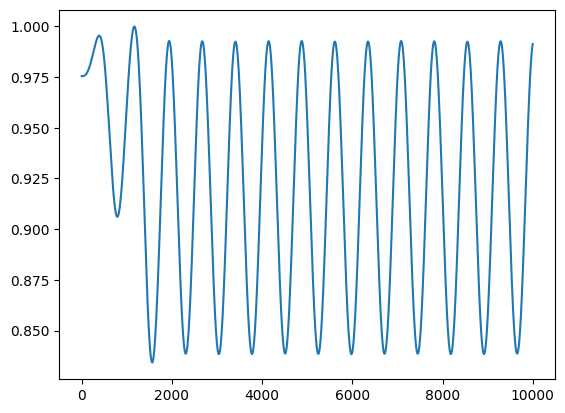

In [15]:
plt.plot(X[:,3].real)

In [16]:
newX = np.zeros((X.shape[0], 16))
for i in range(0,3):
    newX[i] = np.append(np.array([X[i][0].real, X[i][1].real, X[i][1].imag, X[i][3].real]), np.zeros(12))
for i in range(3, X.shape[0]):
    newX[i] = np.array([X[i][0].real, X[i][1].real, X[i][1].imag, X[i][3].real,
                       X[i-1][0].real, X[i-1][1].real, X[i-1][1].imag, X[i-1][3].real,
                       X[i-2][0].real, X[i-2][1].real, X[i-2][1].imag, X[i-2][3].real,
                       X[i-3][0].real, X[i-3][1].real, X[i-3][1].imag, X[i-3][3].real])

In [17]:
newy = np.zeros((y.shape[0],8))
for i in range(y.shape[0]):
    newy[i] = np.array([y[i][0].real, y[i][0].imag, y[i][1].real, y[i][1].imag, y[i][2].real, y[i][2].imag, y[i][3].real, y[i][3].imag])

In [18]:
X = newX
y = newy

In [19]:
# from sklearn.model_selection import train_test_split
# train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.10, random_state=57109, shuffle=True)

In [20]:
train_datat = torch.from_numpy(X)
train_labelst = torch.from_numpy(y)

In [21]:
net = Net(input_size, output_size)
net = net.to(device)

In [22]:
train_datat = train_datat.to(device)
train_labelst = train_labelst.to(device)

In [28]:
from torch.nn.functional import mse_loss
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [29]:
num_epochs = 100000
batch_size = 10000
losses = []
for epoch in range(1, num_epochs + 1):
    final_loss = 0
    for i in range(0, train_datat.shape[0], batch_size):
        optimizer.zero_grad()
        if i + batch_size > train_datat.shape[0]:
            batched_data = train_datat[i:]
        else:
            batched_data = train_datat[i: i + batch_size]
        outputs = net(batched_data)
        loss =  mse_loss(outputs, train_labelst[i: i + batch_size])
        loss.backward()
        optimizer.step()
    losses.append(loss.item()) 
    if epoch % 1000 == 0:
        scheduler.step(loss)
        print('Epoch: {}/{}.............'.format(epoch, num_epochs), end=' ')
        print("Loss: ", loss.item())

Epoch: 1000/100000............. Loss:  0.0007383143655749166
Epoch: 2000/100000............. Loss:  0.0004095371684468778
Epoch: 3000/100000............. Loss:  0.0003516760355482398
Epoch: 4000/100000............. Loss:  0.003760033112898154
Epoch: 5000/100000............. Loss:  0.004303138938250575
Epoch: 6000/100000............. Loss:  0.00024352139195689296
Epoch: 7000/100000............. Loss:  0.00020742666489051185
Epoch: 8000/100000............. Loss:  0.008175205699815386
Epoch: 9000/100000............. Loss:  0.0002809319012039964
Epoch: 10000/100000............. Loss:  0.00021451756876337625
Epoch: 11000/100000............. Loss:  0.0017364330752141883
Epoch: 12000/100000............. Loss:  0.0003285788750550794
Epoch: 13000/100000............. Loss:  0.0005970407721463796
Epoch: 14000/100000............. Loss:  0.0010073893455470316
Epoch: 15000/100000............. Loss:  0.000197613251296652
Epoch: 16000/100000............. Loss:  0.00038046369233807467
Epoch: 17000/1000

In [30]:
pred = net(torch.from_numpy(newX).to(device))
pred

tensor([[ 1.0034e+00,  1.8042e-03, -7.1286e-04,  ..., -3.4649e-04,
         -1.2135e-04, -1.5441e-04],
        [ 1.0034e+00,  1.8042e-03, -7.1286e-04,  ..., -3.4641e-04,
         -1.2135e-04, -1.5442e-04],
        [ 1.0034e+00,  1.8043e-03, -7.1286e-04,  ..., -3.4625e-04,
         -1.2135e-04, -1.5446e-04],
        ...,
        [ 8.9898e-01,  1.0462e-01, -8.8265e-05,  ..., -1.3750e-01,
          2.5156e-03,  2.4597e-03],
        [ 8.9895e-01,  1.0486e-01, -8.8861e-05,  ..., -1.3415e-01,
          2.6153e-03,  2.2113e-03],
        [ 8.9855e-01,  1.0514e-01, -9.5495e-05,  ..., -1.3090e-01,
          2.6427e-03,  1.7851e-03]], device='cuda:0', grad_fn=<AddmmBackward0>)

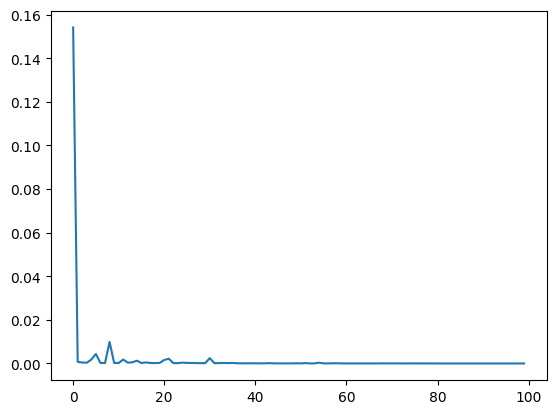

In [31]:
plt.plot(losses[::1000])

In [35]:
print(np.allclose([np.sum(np.abs(pred[i,:].cpu().detach().numpy())**2) for i in range(pred.shape[0])], 1.0, 1e-2))

True


In [36]:
print(np.allclose([np.sum(np.abs(newy[i,:])**2) for i in range(newy.shape[0])], 1.0, 1e-8))

True


In [39]:
newy, newy.shape

(array([[ 1.0000000e+00,  3.3000000e-06,  0.0000000e+00, ...,
         -5.0100000e-06, -1.0000000e-08, -8.0000000e-07],
        [ 1.0000000e+00,  9.9000000e-06,  0.0000000e+00, ...,
         -1.5020000e-05, -4.0000000e-08, -2.3900000e-06],
        [ 1.0000000e+00,  1.9790000e-05,  0.0000000e+00, ...,
         -3.0040000e-05, -1.1000000e-07, -4.7800000e-06],
        ...,
        [ 8.9844212e-01,  1.0444134e-01,  0.0000000e+00, ...,
         -1.3840861e-01,  3.5036700e-03,  6.6731000e-04],
        [ 8.9844212e-01,  1.0444134e-01,  0.0000000e+00, ...,
         -1.3495494e-01,  3.5160200e-03,  5.9886000e-04],
        [ 8.9844212e-01,  1.0444134e-01,  0.0000000e+00, ...,
         -1.3149142e-01,  3.5270300e-03,  5.3017000e-04]]),
 (10000, 8))

In [38]:
x = net(torch.from_numpy(newX).to(device)).cpu()
y = newy
np.linalg.norm((x.detach().numpy()-y))**2

0.1030186812266123

In [40]:
pred.shape

torch.Size([10000, 8])

In [41]:
pred = pred.cpu().detach().numpy()
pred

array([[ 1.00335715e+00,  1.80416134e-03, -7.12863096e-04, ...,
        -3.46488980e-04, -1.21347138e-04, -1.54405505e-04],
       [ 1.00335708e+00,  1.80419074e-03, -7.12860770e-04, ...,
        -3.46411400e-04, -1.21346844e-04, -1.54422589e-04],
       [ 1.00335692e+00,  1.80425231e-03, -7.12855900e-04, ...,
        -3.46248909e-04, -1.21346228e-04, -1.54458371e-04],
       ...,
       [ 8.98979410e-01,  1.04620297e-01, -8.82645432e-05, ...,
        -1.37504289e-01,  2.51564337e-03,  2.45966824e-03],
       [ 8.98952192e-01,  1.04856800e-01, -8.88610514e-05, ...,
        -1.34153372e-01,  2.61526860e-03,  2.21125747e-03],
       [ 8.98554902e-01,  1.05139791e-01, -9.54950178e-05, ...,
        -1.30902210e-01,  2.64265123e-03,  1.78508334e-03]])

In [42]:
assembled_pred = np.zeros((pred.shape[0],4),dtype=np.complex128)
for i in range(pred.shape[0]):
    #import pdb; pdb.set_trace()
    assembled_pred[i] = np.array([pred[i][0] +1j*pred[i][1], pred[i][2] +1j*pred[i][3], pred[i][4] + 1j*pred[i][5], pred[i][6] + 1j*pred[i][7]])
assembled_pred.shape

(10000, 4)

In [43]:
rdmAOpred = np.einsum('ni,nj,ijab->nab',assembled_pred, np.conjugate(assembled_pred), tens)
rdmAOpred.shape

(10000, 2, 2)

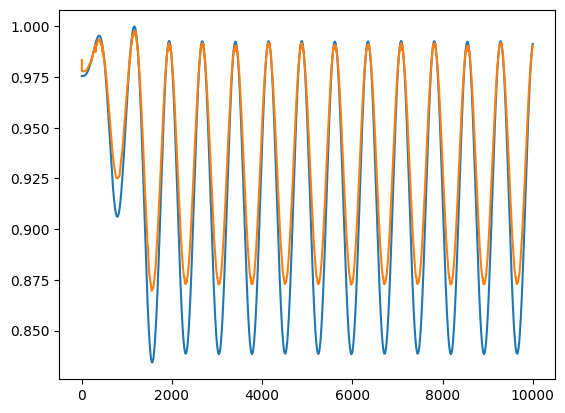

In [49]:
trueden = (rdmAO - np.mean(rdmAO))/(np.max(np.abs(rdmAO - np.mean(rdmAO))))
plt.plot(trueden[:,1,1].real)
plt.plot(rdmAOpred[:,1,1].real)